In [105]:
import preprocess
import tensorflow as tf
import numpy as np
from numpy import load
from numpy.random import randint

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot


In [151]:
# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load('img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    # load labels
    labels = load('img_align_celeba_labels.npz')
    Y = labels['arr_0']
    return X, Y

def generate_samples(dataset, labels, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    ix2 = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X2 = dataset[ix2]
    Y = np.take(labels,ix)
    Y2 = np.take(labels,ix2)
    return X,X2, Y,Y2

class Model(tf.keras.Model):
    def __init__(self, latent_dim=200):
        super(Model, self).__init__()
        self.fc1 = Dense(1024, activation='relu')
        self.fc2 = Dense(latent_dim)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
    def call(self, inputs):
        fc1 = self.fc1(tf.stop_gradient(inputs))
        fc2 = self.fc2(fc1)
        b = tf.math.reduce_sum(fc2,1)
        return b
    def loss(self, logits, labels):

        return (tf.keras.losses.mean_squared_error(labels, logits))
    
def train(encoder,embeddings, dataset, labels, attrs, att, n_epochs=5000, n_batch=128):
    for i in range(n_epochs):
        X,X2,Y,Y2 = generate_samples(dataset,labels,n_batch)
        inputs = []
        for i in range(n_batch):
            diff = attrs[Y2[i]]-attrs[Y[i]]
            emb = [embeddings[att[j]]*diff[j] for j in range(40)]
            inputs.append(emb)
        inputs = tf.constant(inputs, dtype = tf.float32)
        diff_vector = encoder.predict(X2)-encoder.predict(X)
        with tf.GradientTape() as tape:
            outputs=model.call(inputs)
            loss=model.loss(outputs,diff_vector)
        print(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [3]:
encoder = load_model('encoder_model.h5')
generator = load_model('generator_model_100.h5')
embeddings = preprocess.load_embeddings("/git-repos/latent-space-arithmetic/dataset/embedding/glove.6B.50d.txt")

In [4]:
cats,attrs = preprocess.load_attributes("/git-repos/latent-space-arithmetic/dataset/Anno/list_attr_celeba.txt")


In [13]:
dataset, labels = load_real_samples()
labels = tf.constant([int(i[:len(i)-4])-1 for i in labels])

In [6]:
att = ['stubble',
 'arched',
 'attractive',
 'bags',
 'bald',
 'bangs',
 'lips',
 'nose',
 'black',
 'blond',
 'blurry',
 'brown',
 'bushy',
 'chubby',
 'chin',
 'eyeglasses',
 'goatee',
 'gray',
 'makeup',
 'cheekbones',
 'male',
 'open',
 'mustache',
 'narrow',
 'beard',
 'oval',
 'pale',
 'pointy',
 'receding',
 'rosy',
 'sideburns',
 'smiling',
 'straight',
 'wavy',
 'earrings',
 'hat',
 'lipstick',
 'necklace',
 'necktie',
 'young']

In [152]:
model = Model()
train(encoder,embeddings, dataset, labels, attrs, att)

tf.Tensor(56.621857, shape=(), dtype=float32)
tf.Tensor(48.786865, shape=(), dtype=float32)
tf.Tensor(43.784485, shape=(), dtype=float32)
tf.Tensor(41.145187, shape=(), dtype=float32)
tf.Tensor(39.15544, shape=(), dtype=float32)
tf.Tensor(38.698486, shape=(), dtype=float32)
tf.Tensor(37.3831, shape=(), dtype=float32)
tf.Tensor(37.33376, shape=(), dtype=float32)
tf.Tensor(36.81304, shape=(), dtype=float32)
tf.Tensor(36.866814, shape=(), dtype=float32)
tf.Tensor(36.363136, shape=(), dtype=float32)
tf.Tensor(35.81094, shape=(), dtype=float32)
tf.Tensor(35.95375, shape=(), dtype=float32)
tf.Tensor(35.655197, shape=(), dtype=float32)
tf.Tensor(35.59811, shape=(), dtype=float32)
tf.Tensor(35.396065, shape=(), dtype=float32)
tf.Tensor(35.347145, shape=(), dtype=float32)
tf.Tensor(35.549477, shape=(), dtype=float32)
tf.Tensor(35.20794, shape=(), dtype=float32)
tf.Tensor(35.15072, shape=(), dtype=float32)
tf.Tensor(35.49331, shape=(), dtype=float32)
tf.Tensor(35.41173, shape=(), dtype=float32)


KeyboardInterrupt: 

In [119]:
zero = model.call(tf.constant([[-embeddings['pale']]]))

In [120]:
zero_image = (generator.predict(zero)+1)/2

tf.Tensor(
[[-2.79164732e-01 -7.09503740e-02  1.50602730e-02 -3.61652374e-02
  -2.25023851e-01 -1.10573664e-01 -3.61118168e-02 -1.82829112e-01
   3.46654989e-02  8.62427056e-02 -6.16387054e-02  7.63027743e-02
   2.41785105e-02 -2.07906976e-01 -3.60125899e-02  4.43917420e-03
   2.55597383e-01 -3.48960683e-02 -9.37286988e-02 -8.30438267e-03
   2.05686912e-01  1.36946617e-02 -2.06443388e-02  9.53532904e-02
  -1.39310464e-01 -9.99112427e-03 -2.47018233e-01  7.68054947e-02
  -1.57615021e-02 -5.45386076e-02  2.10649706e-02 -4.71082889e-02
  -5.68723232e-02  3.46601531e-02 -5.01602069e-02  4.50672694e-02
  -1.29531816e-01 -6.52714670e-02  2.00105608e-02 -1.09111831e-01
   4.21988033e-02 -1.16988599e-01  1.83306709e-02 -1.06539868e-01
   1.19901083e-01  8.23938847e-03 -1.05508260e-01  6.75697625e-02
   3.60428449e-03 -1.53103128e-01  4.77944389e-02 -8.46511684e-05
  -1.27204627e-01  6.42654225e-02 -1.22403055e-01 -3.63484886e-03
   2.06562027e-01 -4.82516773e-02  4.17143181e-02 -1.04577534e-01

In [121]:
zero_image.shape

(1, 80, 80, 3)

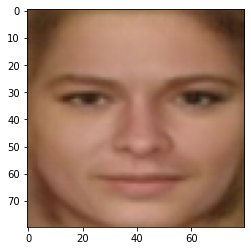

In [122]:
pyplot.imshow(zero_image[0])